In [52]:
from skimage import data as sd
import skimage.color as sc
from skimage.viewer import ImageViewer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

pd.set_option('precision',10)

path = './Both/289250.jpg'

In [53]:
'''
opens image, converts to HSV, returns HSV array, height, width, total number of pixels
'''

def pre_process(path):
    img = sd.imread(path)
    img_hsv = sc.convert_colorspace(img, 'RGB', 'HSV')
    h = img_hsv.shape[0]
    w = img_hsv.shape[1]
    px = h * w
    
    return img_hsv, h, w, px

img_hsv, h, w, px = pre_process(path)

In [ ]:
'''
support function for features 1-3
'''

def make_dataframe(img_hsv):
    height = len(img_hsv)
    width = len(img_hsv[0])
    pixels = height * width
    hue = []
    saturation = []
    value = []
    
    for i in range(height):
        for j in range(width):
            hue.append(img_hsv[i][j][0])
            saturation.append(img_hsv[i][j][1])
            value.append(img_hsv[i][j][2])
            
    data = {'H': hue, 'S': saturation, 'V': value}
    hsv_df = pd.DataFrame(data=data)
    
    return hsv_df, hue, saturation, value

hsv_df, h, s, v = make_dataframe(img_hsv)

In [ ]:
'''
the first two features: average hue, average saturation
'''

def f1_2(hsv_df):
    return hsv_df.mean()['H'], hsv_df.mean()['S']

f1, f2 = f1_2(hsv_df)

In [ ]:
'''
support function for features 3 to 23, k is number of bins
'''
def make_bins(hsv_df, k):
    bins = [0]
    increment = 1/k
    for i in range(k):
        temp = bins[i] + increment
        bins.append(temp)
    hue_bins = pd.cut(hsv_df['H'], bins=bins, include_lowest=True).value_counts()
    return hue_bins

hue_bins = make_bins(hsv_df, 20)

In [ ]:
'''
count the num of hue bins that are most prominent, c is a multiplicatory component
'''
def f3(hue_bins, c):
    
    max_bins = max(hue_bins.tolist())
    count = 0
    
    for i in range(len(hue_bins)):
        if hue_bins[i] > c * max_bins:
            count +=1
            
    return count

f3 = f3(hue_bins, 0.1)

In [ ]:
'''
features 4 to 23, the dispersion of each hue component, returns as list
'''

def f4_23(hue_bins, px):
    hue_bins = hue_bins.sort_index().tolist()
    color_dispersion = []
    for i in range(len(hue_bins)):
        color_dispersion.append(hue_bins[i]/px)
          
    return color_dispersion

f4_23 = f4_23(hue_bins, px)

In [ ]:
from scipy import ndimage

ndimage.measurements.center_of_mass(img_hsv)

In [58]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from skimage.morphology import watershed, disk
from skimage import data
from skimage.filters import rank
from skimage.util import img_as_ubyte

'''
performs water segmentation on images, which will be used for features
'''

def water_segmentation(path,d1,d2,v,d3):

    image = img_as_ubyte(sd.imread(h, as_grey=True))
    print(image.shape)

    # denoise image
    denoised = rank.median(image, disk(d1))

    # find continuous region (low gradient - where less than 10 for this image) --> markers
    # disk(5) is used here to get a more smooth image
    markers = rank.gradient(denoised, disk(d2)) < v
    markers = ndi.label(markers)[0]

    # local gradient (disk(2) is used to keep edges thin)
    gradient = rank.gradient(denoised, disk(d3))

    # process the watershed
    labels = watershed(gradient, markers)
    
    return image, denoised, markers, gradient, labels



In [8]:
labels_df = pd.DataFrame(data=labels)

unique, counts = np.unique(labels, return_counts=True)
unique[0], counts[0]

(1, 349)

In [59]:
'''
displayes the segmentation process
'''

def display_water_segmentation(image, denoised, markers, gradient, labels):

    # display results
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'})
    ax = axes.ravel()

    ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
    ax[0].set_title("Original")

    ax[1].imshow(gradient, cmap=plt.cm.spectral, interpolation='nearest')
    ax[1].set_title("Local Gradient")

    ax[2].imshow(markers, cmap=plt.cm.spectral, interpolation='nearest')
    ax[2].set_title("Markers")

    ax[3].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
    ax[3].imshow(labels, cmap=plt.cm.spectral, interpolation='nearest', alpha=.7)
    ax[3].set_title("Segmented")

    for a in ax:
        a.axis('off')

    fig.tight_layout()
    plt.show()
    
image, denoised, markers, gradient, labels = water_segmentation(path, 2, 5, 10, 2) #original configuration for water shedding
display_water_segmentation(image, denoised, markers, gradient, labels)


AttributeError: 'int' object has no attribute 'read'

/Users/noel/anaconda/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


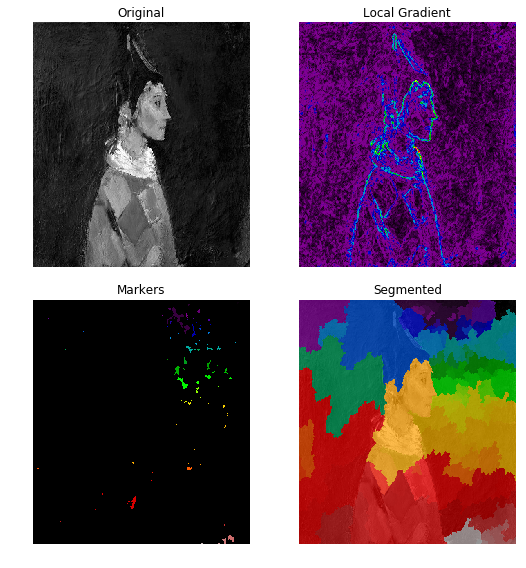

In [55]:
image, denoised, markers, gradient, labels = water_segmentation(path, 2, 6, 8, 2)
display_water_segmentation(image, denoised, markers, gradient, labels)